## Запуск программы

Запуск производится из коммандной строки. Должен быть установлен python (проверка осуществлялась на версии Python 3.7.1, но и для других версий проблем быть не должно). Для удобства желательно, чтобы в одной папке находились:

- файл "Detection.py"

- аудиофайл с шаблонным звуком

- аудиофайл, в котором необходимо найти шаблонный звук (проверялась работа с форматами .wav и .mp3, но программа будет работать с любым форматом, который поддерживает библиотека librosa).

Находясь в этой папке, в коммандной строке нужно ввести:

- **python Detection.py файл1.расширение файл2.расширение**

Например, если нужно искать шаблон "1.wav" в аудиофайле "2.wav", то комманда будет выглядеть следующим образом:

- C:\Users\mserg\Desktop\siemens>**python Detection.py 1.wav 2.wav**

Шаблон можно задавать как первым агрументом, так и вторым, программа считает шаблоном аудиофайл меньшей длительности. Если аудиофайлы не лежат в одной папке с файлом "Detection.py", то необходимо написать вместо названия полный путь. После работы программы будет выведено сообщение о наличии либо отсутствии шаблона в аудиофайле. Более подробное описание программы и алгоритма приведено ниже. 

## Описание программы

Здесь мы подробно рассмотрим работу программы. Нам понадобятся следующие библиотеки:

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import IPython as IP

В качестве конкретного шаблона будем рассматривать звон бокалов (но программа в целом универсальна относительно выбранного шаблона). Требование к шаблону - минимум "молчания" до и после полезного сигнала (иначе необходимо отдельной функцией выделять полезный сигнал). Файл "template.mp3" содержит несколько звуков соударения бокалов, возьмем один из них (можно прослушать).

In [2]:
y_templ, sr_templ = librosa.load('template.mp3')
y_templ = y_templ[7000:25000]
IP.display.Audio(y_templ, rate=sr_templ)

librosa.load позволяет загрузить аудиофайл в виде временного ряда. По умолчанию частота дискретизации составляет 22050 Гц (sample rate - sr) (на секундном интервале получаем 22050 точек, что вполне нас устраивает и обеспечивает хорошую точность).

Далее проведем стандартизацию (вычтем среднее значение и разделим на стандартное отклонение). Данная процедура необходима, потому что алгорим чувствителен к масштабированию данных.

In [3]:
y_templ = (y_templ - y_templ.mean()) / y_templ.std()

Визуализируем полученный временной ряд

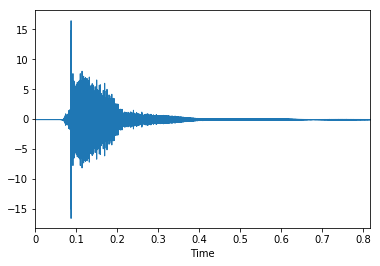

In [4]:
librosa.display.waveplot(y_templ)

Загрузим аудиофайл, в котором будем искать шаблон. Этот файл тоже содержит звон бокалов.

In [5]:
y1, sr1 = librosa.load('zvon.mp3')
IP.display.Audio(y1, rate=sr1)

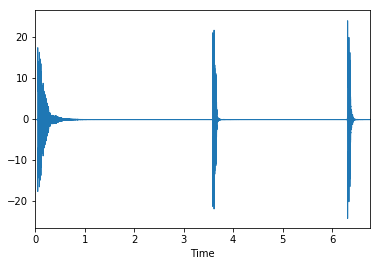

In [6]:
y1 = (y1 - y1.mean()) / y1.std()
librosa.display.waveplot(y1)

Такие представления аудиофайлов имеют что-то общее, но есть очень много звуков другой природы, которые будут похожи на них, и различить их будет крайне трудно. Нам нужно больше информации, поэтому будем использовать MFCC - представление (Мел-частотные кепстральные коэффициенты http://www.speech.cs.cmu.edu/15-492/slides/03_mfcc.pdf). Можно было бы использовать какие-то другие спектральные характеристики, но преимуществами данного метода являются сжатие и фильтрация ненужных данных, а также применимость к человеческой речи.

In [7]:
mfcc_templ = librosa.feature.mfcc(y=y_templ, sr=sr_templ, dct_type=1, norm=None, n_mfcc=50)
mfcc1 = librosa.feature.mfcc(y=y1, sr=sr1, dct_type=1, norm=None, n_mfcc=50)

librosa.feature.mfcc возвращает np.ndarray[shape=(n_mfcc, t)]. Построим для наглядности спектрограммы.

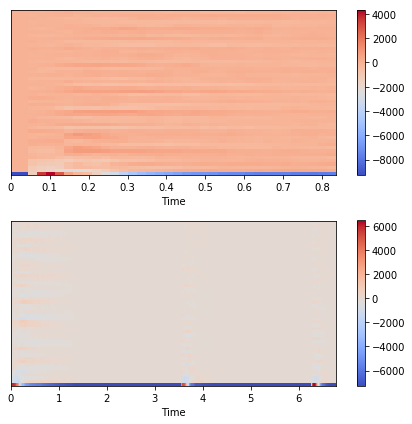

In [8]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(mfcc_templ, sr=sr_templ, x_axis='time')
plt.colorbar()
plt.subplot(2, 1, 2)
librosa.display.specshow(mfcc1, sr=sr1, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.show()

Необходимо понять, насколько похожи спектрограммы в определенный момент времени. В качестве метрики похожести было выбрано косинусное сходство (оно показывает, насколько два вектора близки друг к другу). Если даны два вектора признаков, A и B, то косинусное сходство, cos(θ), может быть представлено через скалярное произведение и норму:
$$similarity = cos(\theta) = \frac{A\cdot B}{\|A\| \|B\|}$$

Следующая функция позволяет сравнить два MFCC-представления. То есть в каждый момент времени вычисляется косинус между векторами MFCC, потом считается среднее по разным моментам времени.

In [9]:
def compare(X, Y):
    scalar = np.sum(X * Y, axis=0)
    cos = scalar / (norm(X, axis=0) * norm(Y, axis=0))
    return np.mean(cos)

Далее проходим окном с шириной, равной длительности шаблона, по второму аудиофайлу и находим максимальное среднее значение косинуса. Значение косинуса меняется от -1 до 1. Но в действительности в этой задаче почти всегда значение будет от 0 до 1. Таким образом, чем больше значение косинуса, тем более похожи MFCC-представления.

In [10]:
def search(MFCC1, MFCC2):
    it = 0
    L1 = MFCC1.shape[1]
    L2 = MFCC2.shape[1]
    MAX = -999
    if L1 > L2:
        Big = MFCC1
        Small = MFCC2
        for i in range(L1-L2+1):
            if compare(Small, Big[:,i:i+L2]) > MAX:
                it=i
            MAX = max(MAX, compare(Small, Big[:,i:i+L2]))
    elif L2 > L1:
        Big = MFCC2
        Small = MFCC1
        for i in range(L2-L1+1):
            if compare(Small, Big[:,i:i+L1]) > MAX:
                it=i
            MAX = max(MAX, compare(Small, Big[:,i:i+L1]))
    else:
        return compare(MFCC1, MFCC2)  
    return MAX, it

Осталось выбрать пороговое значение, превышение которого будет означать, что аудиофайл содержит шаблон. Значение порога можно регулировать в зависимости от наших желаний. Если мы хотим найти в точности шаблонный звук, порог можно увеличить. Если мы хотим найти похожий звук той же природы, порог можно опустить. Я на свое усмотрение и на свой слух примерно выбрал порог (0.7) таким образом, чтобы детектировался не только точно такой же звук, как в шаблоне, но и похожие на него. 

Проверим алгоритм на нашем примере

In [11]:
search(mfcc_templ, mfcc1)[0]

0.8634082026620544

Очевидно, что звон бокалов присутствует в обоих файлах.

Если шаблон присутствует в файле несколько раз, программа найдет наиболее похожий на шаблон участок (если нам нужны все совпадения, программу можно модифицировать). Визуализируем полученный результат (MFCC сжимает исходный ряд в 512 раз, отсюда умножение на 512):

In [12]:
it = search(mfcc_templ, mfcc1)[1]

(0, 7)

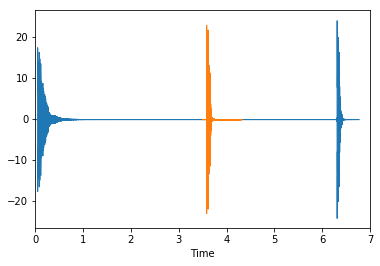

In [13]:
librosa.display.waveplot(y1)
librosa.display.waveplot(y1[it*512:(it+mfcc_templ.shape[1])*512], offset=it*512/22050)
plt.xlim(0, 7)

Возьмем звук разбитого стекла, который, на мой взгляд, похож на звон бокалов (хотя бы по своей природе).

In [14]:
y2, sr2 = librosa.load('break.mp3')
IP.display.Audio(y2, rate=sr2)

In [15]:
y2 = (y2 - y2.mean()) / y2.std()
mfcc2 = librosa.feature.mfcc(y=y2, sr=sr2, dct_type=1, n_mfcc=50, norm=None)
search(mfcc_templ, mfcc2)[0]

0.7331087084732574

При пороге 0.7 получится, что мы ошибочно нашли шаблонный звук в данном аудиофайле. Данный пример наглядно демонстрирует, что выбор порога в данном алгоритме очень важен. Конкретное значение порога зависит от конкретной задачи. Если мы имеем дело с задачей классификации, то нужно понимать, что нам важнее, точность или полнота (можно построить ROC - кривую). Я на свое усмотрение оставляю порог 0.7, отдавая предпочтение полноте, так как вижу этот алгорим хорошим для предварительного анализа данных. Представим, что мы осуществляем поиск конкретного звука среди огромного количества различных звуков. Тогда этот быстрый алгоритм (работает за линейное время) найдет нам похожие звуки, а далее мы можем проводить поиск другими более сложными алгоритмами, но уже по значительно меньшему объему данных.

Давайте в качетсве еще одного примера загрузим аудиофайл, который не имеет никакого отношения к звону бокалов (сигнализация).

In [16]:
y3, sr3= librosa.load('1.wav')
IP.display.Audio(y3, rate=sr3)

In [17]:
y3 = (y3 - y3.mean()) / y3.std()
mfcc3 = librosa.feature.mfcc(y=y3, sr=sr3, dct_type=1, n_mfcc=50, norm=None)
search(mfcc_templ, mfcc3)[0]

0.27029745670369804

Видно, что различия в этих аудиофайлах очень большие. Но давайте загрузим другую сигнализацию.

In [18]:
y4, sr4 = librosa.load('2.wav')
IP.display.Audio(y4, rate=sr4)

In [19]:
y4 = (y4 - y4.mean()) / y4.std()
mfcc4 = librosa.feature.mfcc(y=y4, sr=sr4, dct_type=1, n_mfcc=50, norm=None)
search(mfcc3, mfcc4)[0]

0.9012617830414966

Теперь немного об устойчивости к шуму.
Возьмем аудиофайл "template.mp3", из которого мы вырезали шаблон. 

In [20]:
y5, sr5 = librosa.load('template.mp3')
IP.display.Audio(y5, rate=sr5)

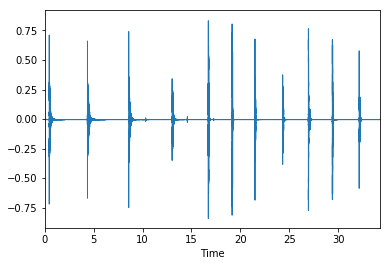

In [21]:
librosa.display.waveplot(y5)

Добавим случайный шум из равномерного распределения с максимальной амлитудой, равной 0.1 от стандартного отклонения.

In [22]:
y5_noise = y5 + np.random.rand(len(y5)) * 0.1 * np.std(y5)

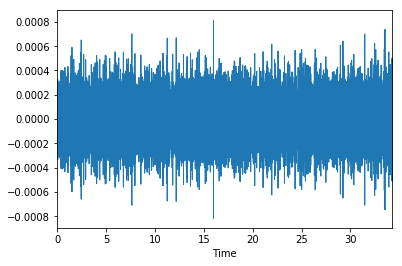

In [23]:
librosa.display.waveplot(y5 - y5_noise)

Будем увеличивать амплитуду шума и построим график зависимости значения косинуса от амлитуды шума в единицах стандартного отклонения

In [24]:
score=[]
for el in np.linspace(0, 0.45, 100):
    y5_noise = y5 + np.random.rand(len(y5)) * el * np.std(y5)
    y5_noise = (y5_noise - y5_noise.mean()) / y5_noise.std()
    mfcc5_noise = librosa.feature.mfcc(y=y5_noise, sr=sr5, dct_type=1, n_mfcc=50, norm=None)
    score.append(search(mfcc_templ, mfcc5_noise)[0])

Text(0, 0.5, 'Значение косинуса')

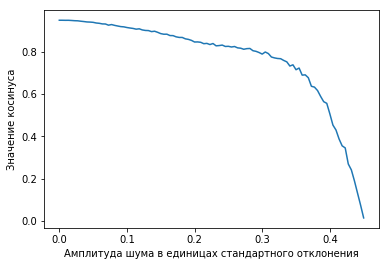

In [25]:
plt.plot(np.linspace(0, 0.45, 100), score)
plt.xlabel('Амплитуда шума в единицах стандартного отклонения')
plt.ylabel('Значение косинуса')

Можно заметить, что качество не так быстро падает с увеличением амплитуды шума. При амплитуде шума, меньшей 0.35 $\sigma$, алгоритм показывает хороший результат.

В заключение рассмотрим работу программы с человеческим языком. Я записал на диктофон телефона шаблон (слово) и фразу, в которой содержится это слово.

In [26]:
y_word, sr_word = librosa.load('word.mp3') 
IP.display.Audio(y_word, rate=sr_word)

In [27]:
y_phrase, sr_phrase = librosa.load('phrase.mp3')
IP.display.Audio(y_phrase, rate=sr_phrase)

In [28]:
y_word = y_word[15000:28000]
y_word = (y_word - y_word.mean()) / y_word.std()
y_phrase = (y_phrase - y_phrase.mean()) / y_phrase.std()
mfcc_word = librosa.feature.mfcc(y=y_word, sr=sr_word, dct_type=1, norm=None, n_mfcc=50)
mfcc_phrase = librosa.feature.mfcc(y=y_phrase, sr=sr_phrase, dct_type=1, norm=None, n_mfcc=50)
search(mfcc_word, mfcc_phrase)[0]

0.8460713553664008

(0, 7)

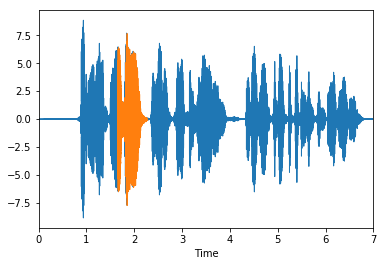

In [29]:
it = search(mfcc_word, mfcc_phrase)[1]
librosa.display.waveplot(y_phrase)
librosa.display.waveplot(y_phrase[it*512:(it+mfcc_word.shape[1])*512], offset=it*512/22050)
plt.xlim(0, 7)

**Спасибо за внимание!**